In [4]:
%matplotlib inline
import sys
import os

path_to_mickey = sys.path[0].rsplit(os.sep, 1)[0]

sys.path.append(
    path_to_mickey
)

In [7]:
import torch
import argparse
from lib.models.builder import build_model
from lib.datasets.utils import correct_intrinsic_scale
from lib.models.MicKey.modules.utils.training_utils import colorize, generate_heat_map
from lib.demo.utils import prepare_score_map, colorize_depth, read_color_image, read_intrinsics
from config.default import cfg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path
import cv2
from IPython.display import clear_output

In [8]:
im_path_ref = "../data/toy_example/im0.jpg"
im_path_dst = "../data/toy_example/im1.jpg"
intrinsics = "../data/toy_example/intrinsics.txt"
checkpoint = "../weights/mickey.ckpt"
config = "../config/MicKey/curriculum_learning.yaml"
resize = None

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

print('Preparing data...')

# Prepare config file
cfg.merge_from_file(config)

# Prepare the model
model = build_model(cfg, checkpoint=checkpoint)

# Load demo images
im0 = read_color_image(im_path_ref, resize).to(device)
im1 = read_color_image(im_path_dst, resize).to(device)

# Load intrinsics
K = read_intrinsics(intrinsics, resize)

# Prepare data for MicKey
data = {}
data['image0'] = im0
data['image1'] = im1
data['K_color0'] = torch.from_numpy(K['im0.jpg']).unsqueeze(0).to(device)
data['K_color1'] = torch.from_numpy(K['im1.jpg']).unsqueeze(0).to(device)

Preparing data...


In [9]:
# Run inference
print('Running MicKey relative pose estimation...')
model(data)

# Pose, inliers and score are stored in:
# data['R'] = R
# data['t'] = t
# data['inliers'] = inliers
# data['inliers_list'] = inliers_list

print('Saving depth and score maps in image directory ...')
depth0_map = colorize_depth(data['depth0_map'][0], invalid_mask=(data['depth0_map'][0] < 0.001).cpu()[0])
depth1_map = colorize_depth(data['depth1_map'][0], invalid_mask=(data['depth1_map'][0] < 0.001).cpu()[0])
score0_map = prepare_score_map(data['scr0'][0], data['image0'][0], temperature=0.5)
score1_map = prepare_score_map(data['scr1'][0], data['image1'][0], temperature=0.5)

ext_im0 = im_path_ref.split('.')[-1]
ext_im1 = im_path_dst.split('.')[-1]

cv2.imwrite(im_path_ref.replace(ext_im0, 'score.jpg'), score0_map)
cv2.imwrite(im_path_dst.replace(ext_im1, 'score.jpg'), score1_map)

cv2.imwrite(im_path_ref.replace(ext_im0, 'depth.jpg'), depth0_map)
cv2.imwrite(im_path_dst.replace(ext_im1, 'depth.jpg'), depth1_map)

Running MicKey relative pose estimation...
Saving depth and score maps in image directory ...


True

In [10]:
list(data.keys())

['image0',
 'image1',
 'K_color0',
 'K_color1',
 'kps0_shape',
 'kps1_shape',
 'depth0_map',
 'depth1_map',
 'down_factor',
 'kps0',
 'depth_kp0',
 'scr0',
 'kps1',
 'depth_kp1',
 'scr1',
 'scores',
 'dsc0',
 'dsc1',
 'kp_scores',
 'final_scores',
 'R',
 't',
 'inliers',
 'inliers_list']

In [11]:
# indices 0 and 1 are key point for ref image
# indices 2 and 3 are key point for query image
data['inliers_list'][0].shape

torch.Size([1311, 7])

In [12]:
img_pts = data['inliers_list'][0].detach().cpu()

KeyboardInterrupt: 

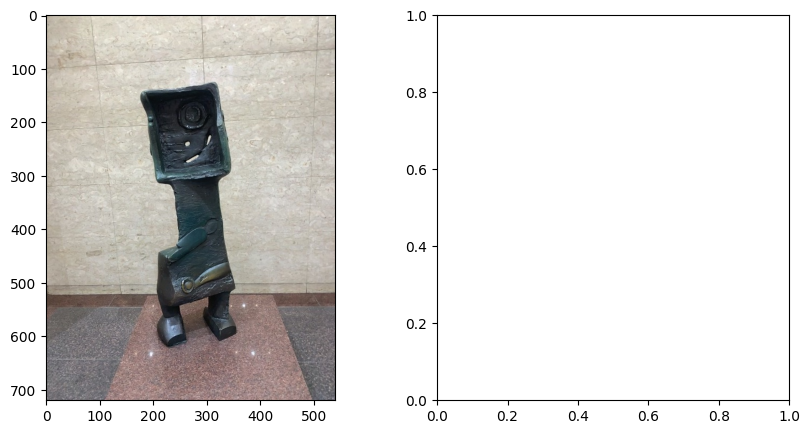

In [16]:
import matplotlib
import time
# Load the image
reference_img = mpimg.imread(im_path_ref)
query_img = mpimg.imread(im_path_dst)

def plot_images_correspondences(axis, x, y, color, img, title):
    axis.imshow(img)
    axis.scatter(x, y, color=color, s=1)
    axis.set_title(title)


# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# # display query and reference images and points
# plot_images_correspondences(axes[0], img_pts[:, 0], img_pts[:, 1], "red", reference_img, "Reference Image")
# plot_images_correspondences(axes[1], img_pts[:, 2], img_pts[:, 3], "blue", query_img, "Query Image")

# draw lines connecting points between images
for j in range(img_pts.shape[0]):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_images_correspondences(axes[0], img_pts[:, 0], img_pts[:, 1], "red", reference_img, "Reference Image")
    plot_images_correspondences(axes[1], img_pts[:, 2], img_pts[:, 3], "blue", query_img, "Query Image")
    for i in range(j + 1):
        
        con = matplotlib.patches.ConnectionPatch(xyA=img_pts[i, :2], xyB=img_pts[i, 2:4], coordsA="data", coordsB="data",
                                  axesA=axes[0], axesB=axes[1], color="green")
        axes[1].add_artist(con)
        
    plt.show()
    time.sleep(0.5)
    print("plotting")
    clear_output(wait=True)
    

